## Carregar Dados

In [ ]:
# Carregar Bibliotecas
import pandas as pd
import numpy as np

# Bibliotecas de vizualização
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de modelagem
from sklearn.model_selection import train_test_split, StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, roc_auc_score, f1_score, accuracy_score
from category_encoders import CatBoostEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import optuna as opt

# Configurar Warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
# Importar Dados
# Dados https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

customers = pd.read_csv("../Data/olist_customers_dataset.csv")
orders = pd.read_csv("../Data/olist_orders_dataset.csv")
order_items = pd.read_csv("../Data/olist_order_items_dataset.csv")

## EDA

In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [6]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [7]:
# Agrupar DataFrames
df = pd.merge(orders, customers, on = 'customer_id')
df = pd.merge(df, order_items, on='order_id')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   customer_id                    112650 non-null  object 
 2   order_status                   112650 non-null  object 
 3   order_purchase_timestamp       112650 non-null  object 
 4   order_approved_at              112635 non-null  object 
 5   order_delivered_carrier_date   111456 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  112650 non-null  object 
 8   customer_unique_id             112650 non-null  object 
 9   customer_zip_code_prefix       112650 non-null  int64  
 10  customer_city                  112650 non-null  object 
 11  customer_state                 112650 non-null  object 
 12  order_item_id                 

In [8]:
print(f"O Dataframe possui {df.shape[0]} linhas e {df.shape[1]} colunas.")

O Dataframe possui 112650 linhas e 18 colunas.


In [9]:
df.describe()

,customer_zip_code_prefix,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000,112650.000000
mean,35119.309090,1.197834,120.653739,19.990320
std,29866.120801,0.705124,183.633928,15.806405
min,1003.000000,1.000000,0.850000,0.000000
25%,11310.000000,1.000000,39.900000,13.080000
50%,24340.000000,1.000000,74.990000,16.260000
75%,59028.750000,1.000000,134.900000,21.150000
max,99990.000000,21.000000,6735.000000,409.680000


In [10]:
# Verificar valores nulos
null_values = df.isnull().sum()
null_values

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
dtype: int64

In [11]:
# Separar Linhas e Colunas
rows, columns = df.shape

In [12]:
# Verificar percentual de valores Nulos
percent_nan = ((df.isnull().sum()/rows)*100).round(2)
percent_nan

order_id                         0.00
customer_id                      0.00
order_status                     0.00
order_purchase_timestamp         0.00
order_approved_at                0.01
order_delivered_carrier_date     1.06
order_delivered_customer_date    2.18
order_estimated_delivery_date    0.00
customer_unique_id               0.00
customer_zip_code_prefix         0.00
customer_city                    0.00
customer_state                   0.00
order_item_id                    0.00
product_id                       0.00
seller_id                        0.00
shipping_limit_date              0.00
price                            0.00
freight_value                    0.00
dtype: float64

In [13]:
# Verificar valores duplicados
df[df.duplicated()].sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date       0
order_delivered_customer_date      0
order_estimated_delivery_date      0
customer_unique_id                 0
customer_zip_code_prefix           0
customer_city                      0
customer_state                     0
order_item_id                      0
product_id                         0
seller_id                          0
shipping_limit_date                0
price                            0.0
freight_value                    0.0
dtype: object

In [14]:
# Criar uma lista de dicionários com o nome da coluna e a contagem de valores distintos
data = [{'Variavel': column, 'contagem_distinta': df[column].nunique()} for column in df.columns]

# Criar o DataFrame a partir da lista de dicionários
count = pd.DataFrame(data)

# Exibir o DataFrame
count

,Variavel,contagem_distinta
0,order_id,98666
1,customer_id,98666
2,order_status,7
3,order_purchase_timestamp,98112
4,order_approved_at,90174
5,order_delivered_carrier_date,81017
6,order_delivered_customer_date,95664
7,order_estimated_delivery_date,450
8,customer_unique_id,95420
9,customer_zip_code_prefix,14976


In [15]:
# Verificar quantidade de diferente tipos de status do pedido
order_status_count = df['order_status'].value_counts().reset_index()
order_status_count.columns = ['status_pedido', 'contagem']

order_status_count

,status_pedido,contagem
0,delivered,110197
1,shipped,1185
2,canceled,542
3,invoiced,359
4,processing,357
5,unavailable,7
6,approved,3


In [16]:
# Verificar quantidade de diferente tipos de status do pedido
customer_state_count = df['customer_state'].value_counts().reset_index()
customer_state_count.columns = ['estado', 'contagem']

customer_state_count = customer_state_count.head(10)
customer_state_count

,estado,contagem
0,SP,47449
1,RJ,14579
2,MG,13129
3,RS,6235
4,PR,5740
5,SC,4176
6,BA,3799
7,DF,2406
8,GO,2333
9,ES,2256


In [17]:
# Vizualizar Histograma dos Pedidos por Estado
fig = px.bar(customer_state_count, x='estado', y='contagem', color='estado',
            title='Pedidos por Estado', text='contagem',
            labels={'estado': 'Estados', 'contagem': 'Quantidade de Produtos'})

fig.update_traces(textposition='outside', texttemplate='%{text}', textfont_size=12)
fig.show()

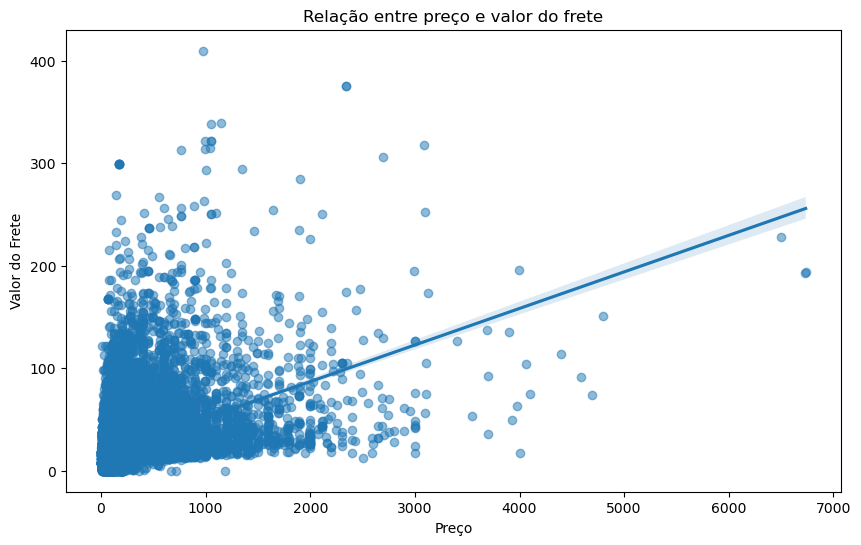

In [18]:
# Vizualizar Correlação
# Vizualizar Dispersão
# Valores de Preço x Valor do Frete
plt.figure(figsize=(10,6))
sns.regplot(x='price', y='freight_value', data=df, scatter_kws={'alpha':0.5})

plt.title('Relação entre preço e valor do frete')
plt.xlabel('Preço')
plt.ylabel('Valor do Frete')

plt.show()

In [19]:
# Verificar Valor de Correlação 
# Valores de Preço x Valor do Frete 
df['price'].corr(df['freight_value'])

0.41420431036303473

In [20]:
# Excluir colunas não úteis
columns_drop = ['order_id',
                'customer_id',
                'product_id',
                'seller_id',
                'order_approved_at',
                'order_delivered_carrier_date',
                'order_delivered_customer_date',
                'order_estimated_delivery_date',
                'shipping_limit_date'
               ]

df.drop(columns=columns_drop, inplace=True)
df.head()

,order_status,order_purchase_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,price,freight_value
0,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,29.99,8.72
1,delivered,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,118.70,22.76
2,delivered,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,159.90,19.22
3,delivered,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,45.00,27.20
4,delivered,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,19.90,8.72


In [21]:
# Criar coluna com valor total do produto
df['total_order_value'] = df['price'] + df['freight_value']
df.head()

,order_status,order_purchase_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,price,freight_value,total_order_value
0,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,29.99,8.72,38.71
1,delivered,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,118.70,22.76,141.46
2,delivered,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,159.90,19.22,179.12
3,delivered,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,45.00,27.20,72.20
4,delivered,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,19.90,8.72,28.62


In [22]:
# Transformar prefixo de endereço do cliente em texto
df['customer_zip_code_prefix'] = df['customer_zip_code_prefix'].astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_status              112650 non-null  object 
 1   order_purchase_timestamp  112650 non-null  object 
 2   customer_unique_id        112650 non-null  object 
 3   customer_zip_code_prefix  112650 non-null  object 
 4   customer_city             112650 non-null  object 
 5   customer_state            112650 non-null  object 
 6   order_item_id             112650 non-null  int64  
 7   price                     112650 non-null  float64
 8   freight_value             112650 non-null  float64
 9   total_order_value         112650 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 8.6+ MB


In [23]:
# Alterar tipo de coluna para data
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_status              112650 non-null  object        
 1   order_purchase_timestamp  112650 non-null  datetime64[ns]
 2   customer_unique_id        112650 non-null  object        
 3   customer_zip_code_prefix  112650 non-null  object        
 4   customer_city             112650 non-null  object        
 5   customer_state            112650 non-null  object        
 6   order_item_id             112650 non-null  int64         
 7   price                     112650 non-null  float64       
 8   freight_value             112650 non-null  float64       
 9   total_order_value         112650 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 8.6+ MB


In [24]:
# Coletar data mais antiga no dataframe
latest_date = df['order_purchase_timestamp'].max()
latest_date

Timestamp('2018-09-03 09:06:57')

In [25]:
# Criar coluna de data mais recente 
df['recent_date'] = (latest_date - df.groupby('customer_unique_id')['order_purchase_timestamp'].transform('max')).dt.days

df.head()

,order_status,order_purchase_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,price,freight_value,total_order_value,recent_date
0,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,29.99,8.72,38.71,335
1,delivered,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,118.70,22.76,141.46,40
2,delivered,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,159.90,19.22,179.12,26
3,delivered,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,45.00,27.20,72.20,288
4,delivered,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,19.90,8.72,28.62,201


In [26]:
# Definir periodo de CHURN
churn_period = 365

# Criar coluna de Churn
# 1 = Cliente é CHURN
# 0 = Cliente não é CHURN
df['churn'] = np.where(df['recent_date'] > churn_period, 1, 0)

df.head()

,order_status,order_purchase_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,price,freight_value,total_order_value,recent_date,churn
0,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,29.99,8.72,38.71,335,0
1,delivered,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,118.70,22.76,141.46,40,0
2,delivered,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,159.90,19.22,179.12,26,0
3,delivered,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,45.00,27.20,72.20,288,0
4,delivered,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,19.90,8.72,28.62,201,0


In [27]:
# Visualizar valor de CHURN
df['churn'].value_counts()

churn
0    87074
1    25576
Name: count, dtype: int64

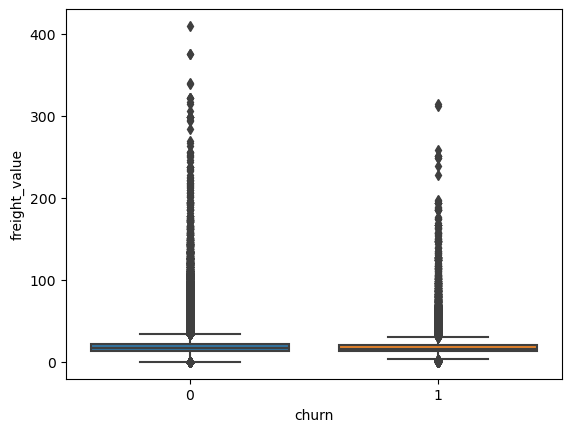

In [28]:
# Visualizar boxplot CHURN x Valor de Frete 
fig = sns.boxplot(x='churn', y='freight_value', data=df)

<Axes: xlabel='freight_value', ylabel='Count'>

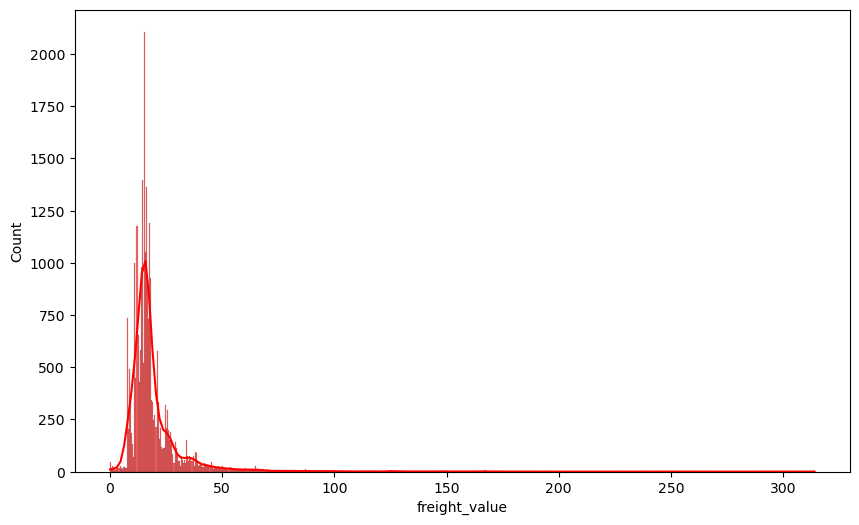

In [29]:
# Visualizar Histograma CHURN positivo x Valor de Frete 
plt.figure(figsize=(10,6))

sns.histplot(data=df[df['churn'] == 1],
             x='freight_value',
             color='red',
             label='churn',
             kde=True,
             alpha=0.6)

<Axes: xlabel='freight_value', ylabel='Count'>

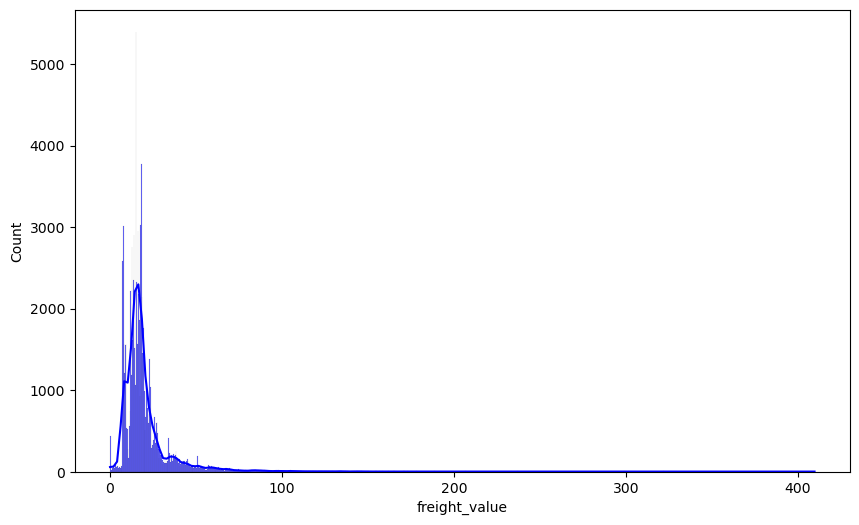

In [30]:
# Visualizar Histograma CHURN negativo x Valor de Frete 
plt.figure(figsize=(10,6))

sns.histplot(data=df[df['churn'] == 0],
             x='freight_value',
             color='blue',
             label='churn',
             kde=True,
             alpha=0.6)

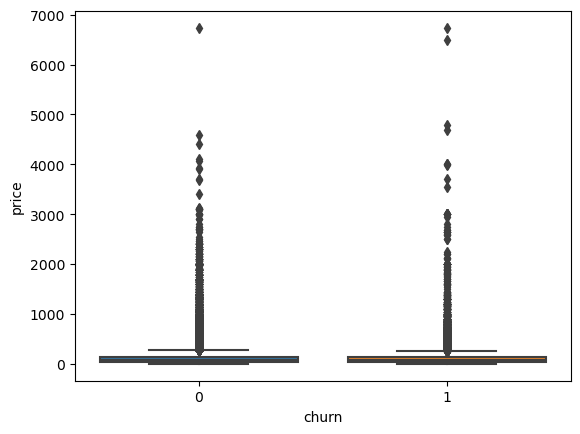

In [31]:
# Visualizar boxplot CHURN x Valor do Produto 
fig = sns.boxplot(x='churn', y='price', data=df)

## Modelagem

In [32]:
# Criar class weight 
# Penalizar classes minoritárias
weights = df['churn'].value_counts(1)[0] / df['churn'].value_counts(1)[1]
weights

3.404519862370973

In [33]:
# Criar x e y do modelo
# Setar colunas não utilizadas para o X 
columns_drop_model = ['churn', 
                     'customer_unique_id',
                      'order_purchase_timestamp',
                      'recent_date'
                     ]
# Setar X
x= df.drop(columns = columns_drop_model, axis = 1)

# Setar y
y= df['churn']

In [34]:
# Separar modelo: treino, teste
X_train, X_test, y_train, y_test =  train_test_split(x, y, 
                                                     test_size = .3, 
                                                     random_state=42, 
                                                     stratify=y)

In [35]:
# Definir XGBoost
xgbboost_model = XGBClassifier(n_estimators=1000,
                               max_depth=8,
                              learning_rate=1e-3,
                              n_jobs=-1,
                              random_state=0,
                              scale_pos_weight = weights,
                              eval_metric='error')

In [36]:
# Definir LightGBM
lightggbm_model = LGBMClassifier(n_estimators=1000,
                               max_depth=8,
                                num_leaves = 2^8,
                              learning_rate=1e-3,
                              n_jobs=-1,
                              random_state=0,
                              is_unbalance=True)

In [37]:
# Definir CatBoost
catboost_model = CatBoostClassifier(n_estimators=1000,
                               max_depth=8,
                              learning_rate=1e-3,
                              random_state=0,
                              scale_pos_weight = weights,
                              verbose=0)

In [38]:
# Definir LogisticRegression
logistic_reg_model = LogisticRegression(random_state=0,
                                        class_weight='balanced',
                                        n_jobs=1,
                                        solver='lbfgs', 
                                        max_iter=1000)

In [39]:
# Definir função para criar nova coluna
def feature_engineering(x_train, x_test):
    x_train['total_order_value'] = x_train['price'] + x_train['freight_value']
    x_test['total_order_value'] = x_test['price'] + x_test['freight_value']
    
    return x_train, x_test

In [40]:
# Função de Validação Cruzada 

def cross_validation(X, y, model, k ,threshold):    
    # Definir StratifiedKFold
    folds = StratifiedKFold(n_splits=k,
                           shuffle=True,
                           random_state=42)
    
    # Definindo as Listas
    precisions = list()
    recalls = list()
    accuracies = list()
    measure_f1= list()
    precisions_recall_auc= list()
    rocs_auc= list()
    
    
    for k, (train_index, test_index) in enumerate(folds.split(x,y)):
    
        # Mostrar fold atual
        print("=-"*6 + f"Fold: {k+1}" + "-="*6)
        
        X_train_intern, y_train_intern = x.iloc[train_index, :], y.iloc[train_index]
        X_test_intern, y_test_intern = x.iloc[test_index, :], y.iloc[test_index]

        # Criando nova coluna
        X_train_intern, X_test_intern = feature_engineering(X_train_intern, X_test_intern)
        
        # Definir variaveis categoricas
        cat_cols = X_train_intern.select_dtypes(include=['object']).columns
        num_cols = X_train_intern.select_dtypes(exclude=['object']).columns
        
        # Tratar variáveis categoricas 
        encoder = CatBoostEncoder()
        cat_imputer = SimpleImputer(strategy='most_frequent')
    
        # Tratar variáveis numéricas
        num_imputer = SimpleImputer(strategy='median')
        
        # Definir Pipelines
        cat_pipeline = Pipeline([('encoder', encoder), ('imputer', cat_imputer)])
        num_pipeline = Pipeline([('imputer', num_imputer)])    
    
        # Aplicar Pipeline nas variaveis de treino
        X_train_intern[cat_cols] = cat_pipeline.fit_transform(X_train_intern[cat_cols], y_train_intern)
        X_train_intern[num_cols] = num_pipeline.fit_transform(X_train_intern[num_cols])
    
    
       # Aplicar Pipeline nas variaveis de teste
        X_test_intern[cat_cols] = cat_pipeline.transform(X_test_intern[cat_cols])
        X_test_intern[num_cols] = num_pipeline.transform(X_test_intern[num_cols])
    
    
        # Treinar modelo XGBboost 
        model.fit(X_train_intern, y_train_intern)
    
        
        y_pred_proba = model.predict_proba(X_test_intern)[:, 1]
        y_pred = np.where(y_pred_proba > threshold, 1, 0)
    
        # Calcular curva
        precision, recall, accuracy = precision_recall_curve(y_test_intern, y_pred)
    
        # Calcular Métricas
        precision_recall_auc = auc(precision, recall)
        roc_auc = roc_auc_score(y_test_intern, y_pred)
        accuracy_scr = accuracy_score(y_test_intern, y_pred)
        precision_scr = precision_score(y_test_intern, y_pred)
        recall_scr = recall_score(y_test_intern, y_pred)
        f1_scr = f1_score(y_test_intern, y_pred) 
    
        # Armazenar score nas listas
        precisions.append(precision_scr)
        recalls.append(recall_scr) 
        accuracies.append(accuracy_scr)
        measure_f1.append(f1_scr)
        precisions_recall_auc.append(precision_recall_auc)
        rocs_auc.append(roc_auc)
    
        print(f"Precisão: {precision_scr:.4f}")
        print(f"Revocação: {recall_scr:.4f}")
        print(f"Acurácia: {accuracy_scr:.4f}")
        print(f"Medida F1: {f1_scr:.4f}")
        print(f"Precisão-Revocação AUC: {precision_recall_auc:.4f}")
        print(f"Roc AUC: {roc_auc:.4f}")
    
    # Transformar list em np.array
    precissions = np.array(precisions)
    recalls = np.array(recalls)
    accuracies = np.array(accuracies)
    measure_f1 = np.array(measure_f1)
    precisions_recall_auc = np.array(precisions_recall_auc)
    rocs_auc = np.array(rocs_auc)
    
    # Calcular médias
    precission_mean = np.mean(precisions)
    recall_mean = np.mean(recalls)
    accuracie_mean = np.mean(accuracies)
    measure_f1_mean = np.mean(measure_f1)
    rocs_auc_mean = np.mean(rocs_auc)
    precision_recall_auc_mean = np.mean(precisions_recall_auc)
    
    # Calcular desvios padrões
    precission_std = np.std(precisions)
    recall_std = np.std(recalls)
    accuracie_std = np.std(accuracies)
    measure_f1_std = np.std(measure_f1)
    rocs_auc_std = np.std(rocs_auc)
    precision_recall_auc_std = np.std(precisions_recall_auc)
    
    print()
    print("=-"*6 + "Exibindo a média das métricas obtidas" + "-="*6)
    print(f"Média da Precisão: {precission_mean:.4f} +/- {precission_std:.4f}")
    print(f"Média da Revocalção: {recall_mean:.4f} +/- {recall_std:.4f}")
    print(f"Média da Acurácia: {accuracie_mean:.4f} +/- {accuracie_std:.4f}")
    print(f"Média da Medida F1: {measure_f1_mean:.4f} +/- {measure_f1_std:.4f}")
    print(f"Média da ROC AUC: {rocs_auc_mean:.4f} +/- {rocs_auc_std:.4f}")
    print(f"Média da PR AUC: {precision_recall_auc_mean:.4f} +/- {precision_recall_auc_std:.4f}")

## LightGBM

In [53]:
cross_validation(x, y, lightggbm_model, k = 5, threshold = 0.5)

=-=-=-=-=-=-Fold: 1-=-=-=-=-=-=
[LightGBM] [Info] Number of positive: 20461, number of negative: 69659
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 90120, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227042 -> initscore=-1.225091
[LightGBM] [Info] Start training from score -1.225091
Precisão: 0.7357
Revocação: 0.0653
Acurácia: 0.7825
Medida F1: 0.1199
Precisão-Revocação AUC: 0.2796
Roc AUC: 0.5292
=-=-=-=-=-=-Fold: 2-=-=-=-=-=-=
[LightGBM] [Info] Number of positive: 20461, number of negative: 69659
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 

## CatBoost

In [41]:
cross_validation(x, y, catboost_model, k = 5, threshold = 0.5)

=-=-=-=-=-=-Fold: 1-=-=-=-=-=-=
Precisão: 0.3155
Revocação: 0.6375
Acurácia: 0.6037
Medida F1: 0.4221
Precisão-Revocação AUC: 0.2906
Roc AUC: 0.6156
=-=-=-=-=-=-Fold: 2-=-=-=-=-=-=
Precisão: 0.3145
Revocação: 0.6182
Acurácia: 0.6074
Medida F1: 0.4169
Precisão-Revocação AUC: 0.2827
Roc AUC: 0.6112
=-=-=-=-=-=-Fold: 3-=-=-=-=-=-=
Precisão: 0.3203
Revocação: 0.6362
Acurácia: 0.6110
Medida F1: 0.4261
Precisão-Revocação AUC: 0.2925
Roc AUC: 0.6199
=-=-=-=-=-=-Fold: 4-=-=-=-=-=-=
Precisão: 0.3194
Revocação: 0.6291
Acurácia: 0.6114
Medida F1: 0.4237
Precisão-Revocação AUC: 0.2893
Roc AUC: 0.6177
=-=-=-=-=-=-Fold: 5-=-=-=-=-=-=
Precisão: 0.3169
Revocação: 0.6271
Acurácia: 0.6084
Medida F1: 0.4210
Precisão-Revocação AUC: 0.2872
Roc AUC: 0.6150

=-=-=-=-=-=-Exibindo a média das métricas obtidas-=-=-=-=-=-=
Média da Precisão: 0.3173 +/- 0.0022
Média da Revocalção: 0.6296 +/- 0.0070
Média da Acurácia: 0.6084 +/- 0.0028
Média da Medida F1: 0.4220 +/- 0.0031
Média da ROC AUC: 0.6159 +/- 0.0029
Média

## Regressão Logística

In [42]:
cross_validation(x, y, logistic_reg_model, k = 5, threshold = 0.5)

=-=-=-=-=-=-Fold: 1-=-=-=-=-=-=
Precisão: 0.2699
Revocação: 0.5357
Acurácia: 0.5656
Medida F1: 0.3589
Precisão-Revocação AUC: 0.2285
Roc AUC: 0.5550
=-=-=-=-=-=-Fold: 2-=-=-=-=-=-=
Precisão: 0.2658
Revocação: 0.5283
Acurácia: 0.5616
Medida F1: 0.3536
Precisão-Revocação AUC: 0.2235
Roc AUC: 0.5498
=-=-=-=-=-=-Fold: 3-=-=-=-=-=-=
Precisão: 0.2722
Revocação: 0.5324
Acurácia: 0.5707
Medida F1: 0.3602
Precisão-Revocação AUC: 0.2283
Roc AUC: 0.5572
=-=-=-=-=-=-Fold: 4-=-=-=-=-=-=
Precisão: 0.2688
Revocação: 0.5439
Acurácia: 0.5606
Medida F1: 0.3598
Precisão-Revocação AUC: 0.2311
Roc AUC: 0.5547
=-=-=-=-=-=-Fold: 5-=-=-=-=-=-=
Precisão: 0.2705
Revocação: 0.5233
Acurácia: 0.5713
Medida F1: 0.3566
Precisão-Revocação AUC: 0.2239
Roc AUC: 0.5543

=-=-=-=-=-=-Exibindo a média das métricas obtidas-=-=-=-=-=-=
Média da Precisão: 0.2694 +/- 0.0021
Média da Revocalção: 0.5327 +/- 0.0070
Média da Acurácia: 0.5660 +/- 0.0044
Média da Medida F1: 0.3578 +/- 0.0024
Média da ROC AUC: 0.5542 +/- 0.0024
Média

## XGBoost

In [43]:
cross_validation(x, y, xgbboost_model, k = 5, threshold = 0.5)

=-=-=-=-=-=-Fold: 1-=-=-=-=-=-=
Precisão: 0.3385
Revocação: 0.7425
Acurácia: 0.6121
Medida F1: 0.4650
Precisão-Revocação AUC: 0.3427
Roc AUC: 0.6582
=-=-=-=-=-=-Fold: 2-=-=-=-=-=-=
Precisão: 0.3397
Revocação: 0.7322
Acurácia: 0.6162
Medida F1: 0.4641
Precisão-Revocação AUC: 0.3393
Roc AUC: 0.6571
=-=-=-=-=-=-Fold: 3-=-=-=-=-=-=
Precisão: 0.3410
Revocação: 0.7392
Acurácia: 0.6164
Medida F1: 0.4667
Precisão-Revocação AUC: 0.3427
Roc AUC: 0.6598
=-=-=-=-=-=-Fold: 4-=-=-=-=-=-=
Precisão: 0.3341
Revocação: 0.7451
Acurácia: 0.6049
Medida F1: 0.4613
Precisão-Revocação AUC: 0.3415
Roc AUC: 0.6544
=-=-=-=-=-=-Fold: 5-=-=-=-=-=-=
Precisão: 0.3365
Revocação: 0.7461
Acurácia: 0.6083
Medida F1: 0.4638
Precisão-Revocação AUC: 0.3430
Roc AUC: 0.6569

=-=-=-=-=-=-Exibindo a média das métricas obtidas-=-=-=-=-=-=
Média da Precisão: 0.3380 +/- 0.0024
Média da Revocalção: 0.7410 +/- 0.0050
Média da Acurácia: 0.6116 +/- 0.0045
Média da Medida F1: 0.4642 +/- 0.0018
Média da ROC AUC: 0.6573 +/- 0.0018
Média

## Tunagem de Hiperparâmetros

In [42]:
# Função de Tunagem de Hiperparâmetros 

def hyperparameter_tuning(trial, k = 5, threshold = 0.5):

    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    subsample = trial.suggest_float('subsample', 0.5, 1, step = 0.1)
    colsample = trial.suggest_float('colsample_bytree', 0.5, 1, step = 0.1)
    min_child_weight = trial.suggest_float('min_child_weight', 1, 20)
    
    # Definir StratifiedKFold
    folds = StratifiedKFold(n_splits=k,
                           shuffle=True,
                           random_state=42)
    
    # Definindo as Listas
    precisions = list()
    recalls = list()
    accuracies = list()
    measure_f1= list()
    precisions_recall_auc= list()
    rocs_auc= list()
    
    
    for k, (train_index, test_index) in enumerate(folds.split(x,y)):
        
        X_train_intern, y_train_intern = x.iloc[train_index, :], y.iloc[train_index]
        X_test_intern, y_test_intern = x.iloc[test_index, :], y.iloc[test_index]
    
        # Definir variaveis categoricas
        cat_cols = X_train_intern.select_dtypes(include=['object']).columns
        num_cols = X_train_intern.select_dtypes(exclude=['object']).columns
        
        # Tratar variáveis categoricas 
        encoder = CatBoostEncoder()
        cat_imputer = SimpleImputer(strategy='most_frequent')
    
        # Tratar variáveis numéricas
        num_imputer = SimpleImputer(strategy='median')
        
        # Definir Pipelines
        cat_pipeline = Pipeline([('encoder', encoder), ('imputer', cat_imputer)])
        num_pipeline = Pipeline([('imputer', num_imputer)])    
    
        # Aplicar Pipeline nas variaveis de treino
        X_train_intern[cat_cols] = cat_pipeline.fit_transform(X_train_intern[cat_cols], y_train_intern)
        X_train_intern[num_cols] = num_pipeline.fit_transform(X_train_intern[num_cols])
    
    
       # Aplicar Pipeline nas variaveis de teste
        X_test_intern[cat_cols] = cat_pipeline.transform(X_test_intern[cat_cols])
        X_test_intern[num_cols] = num_pipeline.transform(X_test_intern[num_cols])
    
    
        # Treinar modelo XGBboost 
        xgbboost_model.fit(X_train_intern, y_train_intern)
    
        
        y_pred_proba = xgbboost_model.predict_proba(X_test_intern)[:, 1]
        y_pred = np.where(y_pred_proba > threshold, 1, 0)
    
        # Calcular curva
        precision, recall, accuracy = precision_recall_curve(y_test_intern, y_pred)
    
        # Calcular Métricas
        precision_recall_auc = auc(precision, recall)
        roc_auc = roc_auc_score(y_test_intern, y_pred)
        accuracy_scr = accuracy_score(y_test_intern, y_pred)
        precision_scr = precision_score(y_test_intern, y_pred)
        recall_scr = recall_score(y_test_intern, y_pred)
        f1_scr = f1_score(y_test_intern, y_pred) 
    
        # Armazenar score nas listas
        precisions.append(precision_scr)
        recalls.append(recall_scr) 
        accuracies.append(accuracy_scr)
        measure_f1.append(f1_scr)
        precisions_recall_auc.append(precision_recall_auc)
        rocs_auc.append(roc_auc)
    
    
    # Transformar list em np.array
    precissions = np.array(precisions)
    recalls = np.array(recalls)
    accuracies = np.array(accuracies)
    measure_f1 = np.array(measure_f1)
    precisions_recall_auc = np.array(precisions_recall_auc)
    rocs_auc = np.array(rocs_auc)
    
    # Calcular médias
    precission_mean = np.mean(precisions)
    recall_mean = np.mean(recalls)
    accuracie_mean = np.mean(accuracies)
    measure_f1_mean = np.mean(measure_f1)
    rocs_auc_mean = np.mean(rocs_auc)
    precision_recall_auc_mean = np.mean(precisions_recall_auc)
    
    # Calcular desvios padrões
    precission_std = np.std(precisions)
    recall_std = np.std(recalls)
    accuracie_std = np.std(accuracies)
    measure_f1_std = np.std(measure_f1)
    rocs_auc_std = np.std(rocs_auc)
    precision_recall_auc_std = np.std(precisions_recall_auc)

    return rocs_auc_mean

study = opt.create_study(direction='maximize')
study.optimize(hyperparameter_tuning, n_trials = 10)

[I 2024-02-15 20:02:37,711] A new study created in memory with name: no-name-06d30fd1-1fff-4180-bc6a-2825354d8295
[I 2024-02-15 20:07:36,757] Trial 0 finished with value: 0.6572825259412138 and parameters: {'learning_rate': 0.04001108412288363, 'max_depth': 15, 'subsample': 1.6, 'colsample_bytree': 2.0, 'min_child_weight': 17.11455667308699}. Best is trial 0 with value: 0.6572825259412138.
[I 2024-02-15 20:12:57,104] Trial 1 finished with value: 0.6572825259412138 and parameters: {'learning_rate': 0.01637375680901873, 'max_depth': 19, 'subsample': 1.1, 'colsample_bytree': 1.2000000000000002, 'min_child_weight': 16.10268435699831}. Best is trial 0 with value: 0.6572825259412138.
[I 2024-02-15 20:18:17,792] Trial 2 finished with value: 0.6572825259412138 and parameters: {'learning_rate': 0.04125210263051933, 'max_depth': 4, 'subsample': 1.7000000000000002, 'colsample_bytree': 1.1, 'min_child_weight': 6.168738428231536}. Best is trial 0 with value: 0.6572825259412138.
[I 2024-02-15 20:23:

In [54]:
params = {'learning_rate': 0.008929238664751489, 'max_depth': 13, 'subsample': 0.4, 'colsample_bytree': 0.8, 'min_child_weight': 5.423001671554306}

In [55]:
xgbboost_model = XGBClassifier(n_estimators=1000,
                              n_jobs=-1,
                              random_state=0,
                              scale_pos_weight = weights,
                              eval_metric='error',
                                       **params)

In [56]:
cross_validation(x, y, xgbboost_model, k = 5, threshold = 0.5)

=-=-=-=-=-=-Fold: 1-=-=-=-=-=-=
Precisão: 0.4263
Revocação: 0.6854
Acurácia: 0.7192
Medida F1: 0.5257
Precisão-Revocação AUC: 0.3646
Roc AUC: 0.7073
=-=-=-=-=-=-Fold: 2-=-=-=-=-=-=
Precisão: 0.4331
Revocação: 0.6616
Acurácia: 0.7265
Medida F1: 0.5235
Precisão-Revocação AUC: 0.3587
Roc AUC: 0.7036
=-=-=-=-=-=-Fold: 3-=-=-=-=-=-=
Precisão: 0.4321
Revocação: 0.6854
Acurácia: 0.7241
Medida F1: 0.5300
Precisão-Revocação AUC: 0.3674
Roc AUC: 0.7104
=-=-=-=-=-=-Fold: 4-=-=-=-=-=-=
Precisão: 0.4317
Revocação: 0.6837
Acurácia: 0.7238
Medida F1: 0.5292
Precisão-Revocação AUC: 0.3666
Roc AUC: 0.7097
=-=-=-=-=-=-Fold: 5-=-=-=-=-=-=
Precisão: 0.4495
Revocação: 0.6489
Acurácia: 0.7398
Medida F1: 0.5311
Precisão-Revocação AUC: 0.3620
Roc AUC: 0.7077

=-=-=-=-=-=-Exibindo a média das métricas obtidas-=-=-=-=-=-=
Média da Precisão: 0.4345 +/- 0.0078
Média da Revocalção: 0.6730 +/- 0.0150
Média da Acurácia: 0.7267 +/- 0.0070
Média da Medida F1: 0.5279 +/- 0.0029
Média da ROC AUC: 0.7077 +/- 0.0024
Média